#**CHAPTER 4.YIELD CURVE DYNAMICS**
---

##0.REFERENCE

https://chatgpt.com/share/6988b9a6-2e94-8012-a24b-d84c2a873a61

##1.CONTEXT

**Introduction**

This notebook sits inside a deliberately narrow idea: in rates markets, the thing you “trade” is not a number called an interest rate. You trade a surface—an entire term structure—and you get paid (or punished) primarily for how that surface bends, steepens, flattens, and warps through regimes. The yield curve is not a cosmetic summary statistic; it is the market’s compression of policy expectations, risk premia, balance-sheet capacity, and liquidity constraints into a tradable geometry. A mechanism-first approach starts there: the curve exists because compensation exists, and compensation exists because risk exists.

In the real world, the short end of the curve is dominated by policy and institutional plumbing. Central banks target an operating rate, implement corridor systems, and influence front-end funding through reserves and collateral dynamics. The long end, by contrast, is a battleground between term premium, inflation uncertainty, risk appetite, and the market’s willingness to warehouse duration. Even when two days show the same 10-year yield, they can be economically opposite: one might be a calm repricing of growth expectations, another a risk-off liquidation that pushes the long end down while liquidity evaporates. This notebook is built to make that distinction explicit. It uses synthetic state variables to separate policy anchoring from term premium shocks and overlays a stress-liquidity regime where execution and constraints become first-order drivers of outcomes.

The mechanism is intentionally exposed through the construction of the tradable surface. The term structure is generated via a Nelson–Siegel representation, a compact three-factor curve model that separates level, slope, and curvature while remaining interpretable. Those factors do not drift aimlessly: they are pushed and pulled by regime-dependent state dynamics. A policy state anchors short tenors so that front-end yields track a policy rate proxy. A term premium state shifts the long end in a way that can persist, mean-revert, or jump depending on regime. A volatility state modulates shock sizes and thereby changes the distribution of curve moves. A liquidity state controls the “price of immediacy,” ensuring that the same trading intention can have radically different realized costs depending on market conditions.

That separation matters because it forces the student to stop thinking in single-variable narratives. “Rates up” is not a mechanism; it is an outcome. Mechanism-first reasoning asks: did the front end move because policy drifted, or because volatility transmitted uncertainty into expectations? Did the long end move because term premium repriced, or because liquidation forced duration hedges into the market? Did curvature change because the belly repriced relative to wings, or because liquidity constraints concentrated impact where dealers could not intermediate? If you cannot answer those questions, you are not trading a market; you are trading an anecdote.

The tradable object in this notebook is not a curve “signal.” It is a set of bond instruments derived from the curve that generate price-based PnL, carry, and financing drag. That is the crucial mechanical step: the environment converts yields into bond prices, and trading takes place through notional positions in bonds at key maturities. The curve is sampled at representative tenors (2Y, 10Y, 30Y) and turned into tradable legs. This enables PnL attribution into components that correspond to real economic effects: price changes from yield moves, carry accrual from holding, and funding or margin drag from leverage and stress.

The action space is deliberately finite and auditable. The agent cannot invent a new trade, cannot tune parameters, cannot add an indicator, and cannot change the environment. It must choose among a small set of canonical curve expressions: FLAT, STEEPENER, FLATTENER, and BUTTERFLY. Each action maps to a DV01-neutral book. DV01 neutrality is not a magic shield; it is a disciplined control that isolates curve shape from outright direction. A steepener book is constructed so that short-end DV01 offsets long-end DV01, aiming to profit if the slope increases. A flattener does the opposite. A butterfly allocates wings against the belly to express curvature. By forcing DV01 neutrality, the notebook makes the key lesson unavoidable: in many environments, shape risk dominates direction risk, but hedging direction does not eliminate convexity, liquidity, financing, or regime risk.

Execution is modeled as a mechanism, not an afterthought. The notebook uses a cost model that mixes proportional costs with volatility-scaled slippage and nonlinear market impact. Liquidity is explicit, so impact is not constant; it becomes worse precisely in the regimes where agents are most tempted to trade aggressively. A permanent component is included as a proxy for adverse price movement caused by your own trading, making it harder to pretend that “transaction costs” are just a small bps haircut. This is not intended to match a particular venue’s microstructure; it is intended to preserve the qualitative truths that rates practitioners learn early: costs are state-dependent, impact is nonlinear, and execution becomes the dominant term when liquidity breaks.

Constraints are enforced as economics. The portfolio is not allowed infinite leverage or unlimited DV01. Position bounds and a leverage cap force scaling when projected exposure exceeds limits. A drawdown stop and deleveraging rule represent institutional survival constraints: a fund that violates risk limits does not get to keep optimizing; it gets flattened. These constraints matter pedagogically because they convert seemingly reasonable theoretical trades into fragile realized outcomes. A strategy that “works” in a frictionless toy world becomes unstable once costs, leverage, and drawdown limits enter the loop.

The agentic structure is designed to be inspectable. Each step logs the state summary, surface summary, chosen action, rationale, executed trades, costs, leverage, and PnL contributions. Telemetry adds decision latency, fallback rates, override events, and constraint-hit counters. This transforms the notebook from a narrative into an auditable laboratory: you can ask not only what happened, but why the system behaved that way under the rules you imposed. If an action changes, you can see whether the change came from regime dynamics, z-scored dislocations, liquidity deterioration, leverage scaling, or LLM decision logic. The point is not to “trust” the agent; it is to treat the agent as an instrument that exposes structure when constrained properly.

The optional LLM policy is not included as an oracle or a forecaster. It is included as a bounded decision layer that must operate within the same constraints as the baseline policy and must output machine-parseable JSON. The LLM sees only a compact context: regime label, a small set of state features, a surface summary, current exposures, leverage, and the last action. It does not see code, cannot change parameters, and cannot expand the action set. If it outputs invalid JSON or an invalid action, the system automatically falls back to the deterministic baseline. This is the correct framing for LLM usage in markets: a policy module is an interface that selects among predefined actions based on structured context, and its reliability is measured through validation, fallbacks, and telemetry rather than narrative plausibility.

The notebook’s learning objective is therefore not “trade this.” It is to train the student’s eye to see the curve as a mechanism-bearing surface and to recognize that realized performance is a product of (i) regime-conditioned curve dynamics, (ii) execution and liquidity conditions, and (iii) institutional constraints. In calm regimes, curve expressions may appear clean: the front end is stable, term premium drifts, carry accrues, and impact is manageable. In stress regimes, the surface behaves differently: term premium can gap, volatility spikes, liquidity collapses, and the cost of turnover rises rapidly. The same trade that looks correct in a slope metric can become wrong once you account for how you must execute it, how it affects leverage, and how your survival constraints respond.

Mechanism-first thinking also changes how you interpret diagnostics. Equity curves are not proof; they are traces of interaction between a policy and an environment. A regime plot is not decoration; it is an explanation of which economic world you were in when PnL accumulated or evaporated. Cost accumulation is not a footnote; it is often the single most reliable explanation for why a plausible trade fails. Action counts are not trivia; they reveal whether the agent is stable or thrashing, whether it is sensitive to noise, and whether constraints are forcing a particular behavior. The interpretive table at the end makes the discipline explicit: for each mechanism, you must state an observation, a fragility mode, and an execution note. That table is a refusal to let performance be the only summary.

Finally, this notebook is designed to be iterated like an engineering experiment. You can alter regime transition probabilities, amplify term premium shocks, tighten leverage caps, or increase impact nonlinearity and observe how the same finite action set changes its realized behavior. You can compare baseline versus LLM decisions under identical market paths. You can stress-test the environment by increasing volatility in the stress regime or by making liquidity state more persistent. Each iteration is not an attempt to “find alpha” but an attempt to map the boundary between theoretical mechanism and realized fragility.

If you take one professional intuition from this laboratory, it should be the following: the yield curve is a tradable object because it encodes compensation for bearing risks that are not visible in a single rate. That compensation tends to look stable in calm regimes and to reprice abruptly under stress. Execution is the conversion mechanism between the model world and the realized world. In rates, the curve’s shape can be the dominant driver of PnL, but the dominant driver of survival is often cost, leverage, and regime transitions. This notebook is built to make that unavoidable.


##2.LIBRARIES AND ENVIRONMENT

In [5]:
!pip install --quiet openai

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json, os
from dataclasses import dataclass

# -------------------------
# Run config (auditable)
# -------------------------
run_config = {
  "chapter_id": 4,
  "chapter_name": "Rates Curve — Yield Curve Dynamics (Nelson–Siegel + DV01-neutral trading)",
  "seed": 11,
  "T": 900,
  "dt": 1.0,

  "regimes": {
    "names": ["policy_easing", "neutral", "policy_tightening", "stress_liquidity"],
    "markov_P": [
      [0.965, 0.030, 0.000, 0.005],
      [0.020, 0.955, 0.020, 0.005],
      [0.000, 0.030, 0.965, 0.005],
      [0.030, 0.150, 0.020, 0.800]
    ],
    "notes": "Regime drives policy drift, term premium shocks, vol, and liquidity."
  },

  "market_params": {
    "mechanism": "front-end policy anchoring + long-end term premium + stress liquidity regime",
    "ns_lambda": 0.55,                 # Nelson–Siegel decay (tenor units: years)
    "policy_rate0": 0.030,
    "beta0_0": 0.020,                  # level
    "beta1_0": -0.010,                 # slope
    "beta2_0": 0.008,                  # curvature
    "mean_reversion": {"beta0":0.0025, "beta1":0.008, "beta2":0.010},
    "shock_scales": {
      "policy_easing":      {"pol":0.00020, "tp":0.00045, "v":0.00035, "liq":0.020},
      "neutral":            {"pol":0.00012, "tp":0.00030, "v":0.00025, "liq":0.015},
      "policy_tightening":  {"pol":0.00020, "tp":0.00045, "v":0.00035, "liq":0.020},
      "stress_liquidity":   {"pol":0.00010, "tp":0.00110, "v":0.00090, "liq":0.090}
    },
    "policy_drifts": {
      "policy_easing": -0.00005,
      "neutral": 0.0,
      "policy_tightening": 0.00005,
      "stress_liquidity": 0.00000
    }
  },

  "surface_params": {
    "surface_type": "curve",
    "tenor_grid_years": [0.5, 1, 2, 3, 5, 7, 10, 20, 30],
    "trade_tenors_years": [2, 10, 30],
    "construction": "Nelson–Siegel yields from (beta0,beta1,beta2,lambda) + policy anchoring"
  },

  "execution_params": {
    "cost_fixed": 0.0,
    "cost_bps": 0.8,               # proportional commission-like
    "slippage_vol_lambda": 1.8,     # scales with vol and trade size
    "impact_eta": 0.12,             # nonlinear impact strength
    "impact_power": 1.35,           # |q|^power
    "permanent_frac": 0.25,         # permanent component fraction
    "min_liquidity": 0.15
  },

  "risk_params": {
    "max_leverage": 2.2,
    "pos_dv01_limit": 18000,        # absolute DV01 per leg (synthetic units)
    "max_dd_stop": 0.22,
    "margin_rate": 0.08,
    "delever_threshold": 0.92       # if equity falls below 92% of peak -> reduce risk
  },

  "policy_params": {
    "enable_llm": True,
    "llm_model": "gpt-4o-mini",
    "llm_temperature": 0.0,
    "fallback_to_baseline_on_error": True
  }
}

np.random.seed(run_config["seed"])
print(json.dumps(run_config, indent=2))

# -------------------------
# Utilities
# -------------------------
def stable_z(x, w=60):
    # rolling z-score with safe guards
    if len(x) < w+5:
        return 0.0
    xs = np.array(x[-w:])
    mu = xs.mean()
    sd = xs.std() + 1e-12
    return float((x[-1] - mu) / sd)

def clamp(x, lo, hi):
    return max(lo, min(hi, x))

logs = []


{
  "chapter_id": 4,
  "chapter_name": "Rates Curve \u2014 Yield Curve Dynamics (Nelson\u2013Siegel + DV01-neutral trading)",
  "seed": 11,
  "T": 900,
  "dt": 1.0,
  "regimes": {
    "names": [
      "policy_easing",
      "neutral",
      "policy_tightening",
      "stress_liquidity"
    ],
    "markov_P": [
      [
        0.965,
        0.03,
        0.0,
        0.005
      ],
      [
        0.02,
        0.955,
        0.02,
        0.005
      ],
      [
        0.0,
        0.03,
        0.965,
        0.005
      ],
      [
        0.03,
        0.15,
        0.02,
        0.8
      ]
    ],
    "notes": "Regime drives policy drift, term premium shocks, vol, and liquidity."
  },
  "market_params": {
    "mechanism": "front-end policy anchoring + long-end term premium + stress liquidity regime",
    "ns_lambda": 0.55,
    "policy_rate0": 0.03,
    "beta0_0": 0.02,
    "beta1_0": -0.01,
    "beta2_0": 0.008,
    "mean_reversion": {
      "beta0": 0.0025,
      "beta1": 0.008,
 

##3.REGIME PROCESS EVOLUTION

###3.1.OVERVIEW

**Cell 3 — Regime process and state evolution**

Cell 3 establishes the economic “world” in which the curve will live. The notebook is mechanism-first, so it cannot begin with a curve formula alone; it must begin with an explicit representation of regimes and the latent state variables that those regimes control. The regime process is implemented as a Markov chain with named regimes that are economically interpretable: policy easing, neutral, policy tightening, and a stress-liquidity regime. This is not a decorative label system. It is the minimal way to encode the empirically central fact that rates dynamics do not have stable parameters across time. The same curve dislocation can mean different things depending on whether policy is anchoring the front end, whether term premium is repricing, or whether liquidity is collapsing.

The cell then defines and evolves the core state variables that drive subsequent surface generation. Policy is a front-end anchor, representing a synthetic policy rate that drifts differently across policy regimes. Term premium is treated as a distinct state because long-end yields cannot be explained by expected short rates alone; they include compensation for duration risk, inflation uncertainty, and balance-sheet constraints. Volatility is modeled as a persistent process that spikes in stress, because curve moves are not homoscedastic; tail risk is regime-conditioned. Liquidity is likewise explicit and persistent, because execution conditions are not constant—they deteriorate precisely when volatility and risk aversion rise.

The Nelson–Siegel factor states (level, slope, curvature) are then evolved with mean reversion plus regime-conditioned shocks and couplings to policy and term premium. This is the key structural bridge: a factor representation is convenient, but it becomes economically meaningful only if its evolution is tied to interpretable forces. Policy anchoring is implemented as a nudging term that links short-tenor behavior to policy changes; term premium loads into factors that affect the long end. The result is not “realistic” in a calibration sense, but it is structurally faithful: regimes modulate drift, shock scale, persistence, and the relationship between front-end and long-end drivers.

From a learning perspective, Cell 3 is where the student should recognize the difference between a model that generates shapes and a model that generates economics. A pure statistical curve model could produce slope oscillations without meaning. Here, slope and curvature are consequences of regime and state. This cell also sets up auditability: because the Markov chain and state transitions are explicit, you can trace any later event—such as a cost explosion or a drawdown—back to a regime transition and state realization. That traceability is essential for a laboratory: you are not trying to be right, you are trying to be explainable under constraints.

Finally, this cell is a foundation for policy behavior. Both baseline and LLM policies will later observe compact summaries of these state variables. If the state is poorly designed, the policy becomes narrative. If the state is mechanistic and interpretable, the policy becomes testable: you can ask whether the agent reacts appropriately to stress-liquidity or whether it persists in trading shape signals when execution conditions make that behavior fragile. Cell 3 defines the “physics” that the rest of the notebook must respect.


###3.2.CODE AND IMPLEMENTATION

In [6]:
# -------------------------
# Regime process + state variables
# -------------------------
reg_names = run_config["regimes"]["names"]
P = np.array(run_config["regimes"]["markov_P"])
T = run_config["T"]

regime = np.zeros(T, dtype=int)
regime[0] = 1  # start neutral

for t in range(1, T):
    regime[t] = np.random.choice(len(reg_names), p=P[regime[t-1]])

# State variables:
# policy_rate_t (front-end anchor), term_premium_t (long-end), vol_t, liquidity_t
policy = np.zeros(T)
term_prem = np.zeros(T)
vol = np.zeros(T)
liq = np.zeros(T)

policy[0] = run_config["market_params"]["policy_rate0"]
term_prem[0] = 0.008
vol[0] = 0.007
liq[0] = 0.55

# Nelson–Siegel factors (beta0 level, beta1 slope, beta2 curvature)
beta0 = np.zeros(T); beta1 = np.zeros(T); beta2 = np.zeros(T)
beta0[0] = run_config["market_params"]["beta0_0"]
beta1[0] = run_config["market_params"]["beta1_0"]
beta2[0] = run_config["market_params"]["beta2_0"]

mr = run_config["market_params"]["mean_reversion"]
sh = run_config["market_params"]["shock_scales"]
dr = run_config["market_params"]["policy_drifts"]

for t in range(1, T):
    rname = reg_names[regime[t]]
    sc = sh[rname]

    # policy: drift + noise, bounded
    policy[t] = policy[t-1] + dr[rname] + np.random.normal(0, sc["pol"])
    policy[t] = clamp(policy[t], -0.005, 0.090)

    # term premium: mean-reverting but regime-shocked
    term_prem[t] = 0.98*term_prem[t-1] + np.random.normal(0, sc["tp"])
    term_prem[t] = clamp(term_prem[t], -0.005, 0.050)

    # vol: persistent, spikes in stress
    vol[t] = 0.92*vol[t-1] + abs(np.random.normal(0, sc["v"]))
    vol[t] = clamp(vol[t], 0.001, 0.060)

    # liquidity: mean-reverting downward in stress
    liq[t] = 0.96*liq[t-1] + np.random.normal(0, sc["liq"])
    liq[t] = clamp(liq[t], run_config["execution_params"]["min_liquidity"], 1.0)

    # NS factors: mean reversion + regime shocks (term premium loads mostly into level & slope)
    beta0[t] = beta0[t-1] + (-mr["beta0"]*(beta0[t-1]-0.02)) + 0.35*term_prem[t] + np.random.normal(0, 0.00035 + 0.30*vol[t])
    beta1[t] = beta1[t-1] + (-mr["beta1"]*(beta1[t-1]+0.01)) + np.random.normal(0, 0.00045 + 0.35*vol[t])
    beta2[t] = beta2[t-1] + (-mr["beta2"]*(beta2[t-1]-0.008)) + np.random.normal(0, 0.00035 + 0.20*vol[t])

    # policy anchoring: force short-tenor yields to track policy by nudging slope
    beta1[t] += 0.55*(policy[t] - policy[t-1])


##4.TRADEABLE SURFACE

###4.1.OVERVIEW

**Cell 4 — Tradable surface construction and bond mechanics**

Cell 4 turns latent economic states into a tradable surface and then into tradable instruments. This is a crucial escalation in realism: a curve is not directly PnL-generating unless you define how you trade it. The notebook therefore constructs a continuous yield curve using the Nelson–Siegel formula, parameterized by the evolving factors from Cell 3. The choice of Nelson–Siegel is pedagogically deliberate. It is expressive enough to generate level, slope, and curvature changes, yet compact enough that each component has an interpretable role. Students can map “what moved” to “which factor moved” without needing a high-dimensional spline or a black-box model.

The surface is not merely plotted; it is sampled at key tenors (2Y, 10Y, 30Y) to define the legs of the trading environment. This sampling creates a concrete bridge between curve geometry and trade expressions. The notebook then computes derived shape measures: slopes such as 2s10 and 10s30, and a curvature measure such as a 2s10s30 fly. These derived measures matter because the agent’s finite action set is expressed in slope and curvature trades rather than in outright yield bets. The surface is therefore “tradable” in the sense that trades refer to explicit functions of the surface.

The second major contribution of Cell 4 is the introduction of bond pricing mechanics. Yields are converted into synthetic bond prices using a fixed-coupon bond model, and sensitivities such as DV01 and convexity are computed. This is where the notebook makes a significant methodological claim: PnL should arise from price changes in instruments, not from algebra on yields. Once you work in price space, several professional realities become available. Duration and convexity emerge naturally as drivers of price response. Carry can be modeled as accrual associated with holding. A DV01-neutral book becomes an actual portfolio construction problem rather than a symbolic hedge. And later, execution costs can be applied to notional trades with a meaningful measure of “size” (DV01 traded).

This cell also sets up fragility in an honest way. DV01 neutrality addresses first-order parallel shift exposure, but it does not neutralize convexity, nor does it neutralize the impact of different tenors reacting differently under regime shifts. By precomputing convexity and DV01, the notebook gives you the instruments to interpret why “hedged” curve books can still behave badly under stress. When volatility is high and term premium gaps, the book can suffer through nonlinear price-yield effects, financing drag, and execution penalties—none of which are visible if you treat yields as the tradable object.

In the agentic flow, Cell 4 is the end of market generation and the beginning of trading realism. It produces the surface objects and the instrument properties that will be referenced by the execution environment and by the action mapping. Without this cell, the notebook would be an abstract curve simulator. With it, the notebook becomes a trading laboratory where curve moves translate into instrument PnL under constraints.


###4.2.CODE AND IMPLEMENTATION

In [7]:
# -------------------------
# Tradable surface: Nelson–Siegel yield curve + bond pricing objects
# -------------------------
lam = run_config["market_params"]["ns_lambda"]
tenor_grid = np.array(run_config["surface_params"]["tenor_grid_years"], dtype=float)
trade_tenors = np.array(run_config["surface_params"]["trade_tenors_years"], dtype=float)

def ns_yield(tau, b0, b1, b2, lam):
    # Nelson–Siegel (continuous)
    x = tau * lam
    # Safe for small x
    f1 = (1 - np.exp(-x)) / (x + 1e-12)
    f2 = f1 - np.exp(-x)
    return b0 + b1*f1 + b2*f2

# Yield curve surface over time (grid)
yc = np.zeros((T, len(tenor_grid)))
# Trade yields at key tenors
y2 = np.zeros(T); y10 = np.zeros(T); y30 = np.zeros(T)

for t in range(T):
    ycurve = ns_yield(tenor_grid, beta0[t], beta1[t], beta2[t], lam)
    # front-end anchoring: blend very short with policy (soft constraint)
    # This keeps the "curve" mechanism explicit: policy pins the front.
    front_blend = 0.65
    for i, tau in enumerate(tenor_grid):
        if tau <= 2.0:
            ycurve[i] = front_blend*policy[t] + (1-front_blend)*ycurve[i]
    yc[t, :] = ycurve
    # sample key tenors by interpolation
    y2[t]  = float(np.interp(2.0, tenor_grid, ycurve))
    y10[t] = float(np.interp(10.0, tenor_grid, ycurve))
    y30[t] = float(np.interp(30.0, tenor_grid, ycurve))

# Bond pricing: synthetic par-ish fixed-coupon bonds (annual pay) as tradable instruments.
# For mechanics: price, duration, convexity drive PnL; plus carry (coupon accrual).
def bond_price(y, maturity, coupon=0.04, freq=2):
    # simple fixed coupon bond pricing using yield y, periodic comp, maturity in years
    n = int(maturity*freq)
    if n <= 0:
        return 1.0
    dt = 1/freq
    r = y/freq
    c = coupon/freq
    disc = 1/(1+r)
    pv = 0.0
    for k in range(1, n+1):
        cf = c
        if k == n:
            cf += 1.0
        pv += cf * (disc**k)
    return pv

def bond_dv01(y, maturity, coupon=0.04, freq=2, bump=1e-4):
    p0 = bond_price(y, maturity, coupon, freq)
    p1 = bond_price(y + bump, maturity, coupon, freq)
    # DV01 ~ -dP/dy * 1bp
    return (p0 - p1)

def bond_convexity(y, maturity, coupon=0.04, freq=2, bump=1e-4):
    p0 = bond_price(y, maturity, coupon, freq)
    p_up = bond_price(y + bump, maturity, coupon, freq)
    p_dn = bond_price(y - bump, maturity, coupon, freq)
    # second derivative approx
    return (p_up - 2*p0 + p_dn) / (bump**2 + 1e-18)

# Precompute prices, dv01, convexity series
coupon = 0.04
P2 = np.zeros(T); P10 = np.zeros(T); P30 = np.zeros(T)
DV2 = np.zeros(T); DV10 = np.zeros(T); DV30 = np.zeros(T)
CX2 = np.zeros(T); CX10 = np.zeros(T); CX30 = np.zeros(T)

for t in range(T):
    P2[t]  = bond_price(y2[t], 2.0, coupon)
    P10[t] = bond_price(y10[t], 10.0, coupon)
    P30[t] = bond_price(y30[t], 30.0, coupon)
    DV2[t]  = bond_dv01(y2[t], 2.0, coupon)
    DV10[t] = bond_dv01(y10[t], 10.0, coupon)
    DV30[t] = bond_dv01(y30[t], 30.0, coupon)
    CX2[t]  = bond_convexity(y2[t], 2.0, coupon)
    CX10[t] = bond_convexity(y10[t], 10.0, coupon)
    CX30[t] = bond_convexity(y30[t], 30.0, coupon)

# Surface summaries
slope_2s10 = y10 - y2
slope_10s30 = y30 - y10
fly_2s10s30 = (y2 + y30 - 2*y10)


##5.EXECUTION AND PORTFOLIO ENVIRONMENT

###5.1.OVERVIEW

**Cell 5 — Execution and portfolio environment under constraints**

Cell 5 defines the environment in which actions become trades and trades become outcomes. In a mechanism-first laboratory, the environment is not a wrapper; it is the economic conversion layer between “theory” and “realized fragility.” This cell therefore constructs a portfolio state with cash, equity, and notional positions in the bond legs. It also defines the components that govern institutional reality: leverage measurement, margin-like drag, position limits, and execution costs that depend on volatility and liquidity.

The execution model is intentionally structured to punish naive turnover. It includes proportional costs, volatility-scaled slippage, and a nonlinear impact term that increases more than linearly with trade size. This aligns with the most important qualitative property of real execution: the marginal cost of trading rises as you trade more, and it rises fastest when the market is least able to absorb flow. Liquidity is an explicit state variable, so impact is regime-conditioned rather than constant. A permanent component acts as a simplified proxy for adverse selection or for the fact that pushing through a market moves the reference price against you. The goal is not microstructure fidelity; it is to make the correct dominance relationships visible. In stress, cost terms should grow and become outcome-determinative.

Risk constraints are also implemented as mechanism, not as disclaimers. A leverage cap forces scaling when projected exposure is too large relative to equity. DV01 limits per leg prevent the policy from “solving” problems by going bigger. A drawdown stop reflects survival constraints: in institutions, a strategy that violates drawdown or VaR constraints does not keep trading; it is reduced or halted. A deleveraging threshold captures the dynamic interplay between equity losses and risk budgets. These constraints create feedback loops that are crucial for professional intuition: losses can force deleveraging, which can force selling into bad liquidity, which can worsen execution costs, which can deepen losses.

The cell also formalizes PnL decomposition. Rather than reporting only a net change in equity, it separates price PnL, carry, and funding drag. This decomposition is the backbone of interpretability. If a curve book loses money, you can ask whether it lost because the curve moved against the shape exposure, because carry was insufficient, because funding drag rose under leverage, or because execution costs dominated. Without this decomposition, the environment becomes an opaque simulator. With it, the environment becomes a diagnostic instrument.

In the agentic flow, Cell 5 is where the notebook’s seriousness is established. Many demonstrations model prices and then “pretend” execution is trivial. This cell refuses that. It sets up an environment in which the policy must survive contact with state-dependent costs and constraints. The learning objective is therefore to internalize that trading is not choosing a direction; it is choosing an exposure under a cost and constraint regime. The environment is the place where that truth becomes quantitative and auditable.


###5.2.CODE AND IMPLEMENTATION

In [8]:
# -------------------------
# Execution + portfolio environment (DV01-neutral books, impact + slippage + margin)
# -------------------------
@dataclass
class Portfolio:
    cash: float = 1_000_000.0     # synthetic currency units
    eq: float = 1_000_000.0
    peak: float = 1_000_000.0
    # positions in "bond notionals" (units of face value)
    n2: float = 0.0
    n10: float = 0.0
    n30: float = 0.0
    last_action: str = "FLAT"

pf = Portfolio()

# Cost bookkeeping
cost_fixed = run_config["execution_params"]["cost_fixed"]
cost_bps = run_config["execution_params"]["cost_bps"] / 1e4
slip_lam = run_config["execution_params"]["slippage_vol_lambda"]
eta = run_config["execution_params"]["impact_eta"]
impact_p = run_config["execution_params"]["impact_power"]
perm_frac = run_config["execution_params"]["permanent_frac"]

# Risk constraints
max_lev = run_config["risk_params"]["max_leverage"]
dv01_lim = run_config["risk_params"]["pos_dv01_limit"]
margin_rate = run_config["risk_params"]["margin_rate"]
max_dd = run_config["risk_params"]["max_dd_stop"]
delever_thr = run_config["risk_params"]["delever_threshold"]

# Permanent impact proxy: we model it by shifting effective yields used for execution pricing.
# Here we approximate price impact directly: worse execution price when trading in illiquid/high vol regimes.
def execution_cost_and_fill(trade_n2, trade_n10, trade_n30, t):
    # trade sizes in notional units; we compute a volume proxy in DV01 space
    dv_trade = abs(trade_n2*DV2[t]) + abs(trade_n10*DV10[t]) + abs(trade_n30*DV30[t])

    # illiquidity amplifies impact
    illiq = (1.0 / max(liq[t], run_config["execution_params"]["min_liquidity"])) - 1.0

    # temporary cost: bps + vol slippage + nonlinear impact
    temp = cost_fixed + cost_bps * dv_trade
    temp += (slip_lam * vol[t]) * (dv_trade / (1e4 + dv_trade))  # vol-scaled saturation
    temp += eta * (dv_trade ** impact_p) * (1e-10) * (1.0 + illiq)  # nonlinear

    # permanent component: worsens mark by shifting prices against us (modeled as extra temp here for auditability)
    perm = perm_frac * temp

    total = temp + perm
    return total, {"temp_cost": temp, "perm_cost": perm, "dv_trade": dv_trade, "illiq": illiq}

def portfolio_leverage(t):
    # gross exposure proxy: sum of absolute market values
    mv = abs(pf.n2*P2[t]) + abs(pf.n10*P10[t]) + abs(pf.n30*P30[t])
    return mv / max(pf.eq, 1e-12)

def dv01_exposures(t):
    return (pf.n2*DV2[t], pf.n10*DV10[t], pf.n30*DV30[t])

def enforce_limits(trade_n2, trade_n10, trade_n30, t):
    # enforce DV01 per-leg limits after trade
    n2 = pf.n2 + trade_n2
    n10 = pf.n10 + trade_n10
    n30 = pf.n30 + trade_n30

    if abs(n2*DV2[t]) > dv01_lim:
        trade_n2 *= (dv01_lim / (abs(n2*DV2[t]) + 1e-12))
    if abs(n10*DV10[t]) > dv01_lim:
        trade_n10 *= (dv01_lim / (abs(n10*DV10[t]) + 1e-12))
    if abs(n30*DV30[t]) > dv01_lim:
        trade_n30 *= (dv01_lim / (abs(n30*DV30[t]) + 1e-12))

    return trade_n2, trade_n10, trade_n30

def step_mark_to_market(t):
    # PnL from price changes (bond mechanics)
    # Use t-1 positions, price change t-1 -> t
    dP2  = P2[t]  - P2[t-1]
    dP10 = P10[t] - P10[t-1]
    dP30 = P30[t] - P30[t-1]

    price_pnl = pf.n2*dP2 + pf.n10*dP10 + pf.n30*dP30

    # Carry approximation: coupon accrual per step (dt=1 assumed "day-like" synthetic; keep small)
    carry = 0.00002 * (abs(pf.n2*P2[t]) + abs(pf.n10*P10[t]) + abs(pf.n30*P30[t]))

    # Financing / margin drag: penalize leverage in stress (funding tightness proxy)
    lev = portfolio_leverage(t)
    funding = margin_rate * max(0.0, lev-1.0) * pf.eq * 1e-3 * (1.0 + (reg_names[regime[t]]=="stress_liquidity")*2.0)

    return price_pnl + carry - funding, {"price_pnl": price_pnl, "carry": carry, "funding": funding}



##6.ACTION SPACE

###6.1.OVERVIEW

**Cell 6 — Constrained action space and DV01-neutral trade mapping**

Cell 6 is the governance and mechanism bridge: it defines what the agent is allowed to do and how those actions translate into precise portfolio targets. The notebook’s thesis depends on the action space being finite, enumerated, and auditable. If the agent could invent instruments or continuous weights freely, the system would collapse into parameter tuning. Instead, the action space consists of canonical curve expressions: FLAT, STEEPENER, FLATTENER, BUTTERFLY. These are not arbitrary labels; they correspond to stable categories of rates trading used to express economic beliefs about policy anchoring, term premium repricing, and curvature distortions.

The mapping from action to targets is mechanical and disciplined. For steepeners and flatteners, the notebook constructs a DV01-neutral 2s10 book by solving for notionals that offset DV01 across the 2Y and 10Y legs. The result is a shape expression: exposure is primarily to slope changes rather than parallel shifts. For the butterfly, the notebook allocates wing positions in 2Y and 30Y against a belly position in 10Y and solves for DV01 neutrality. This construction expresses curvature: it profits when the belly moves differently from the wings.

The importance of DV01 neutrality here is pedagogical. It demonstrates how professionals isolate the dimension they want to trade and control the dimension they want to avoid. Yet, by being explicit about instrument pricing and convexity, the notebook also teaches what DV01 neutrality does not solve. Convexity is not neutralized; financing and liquidity are not neutralized; regime-dependent correlations between curve segments can still break assumptions. Thus, DV01 neutrality becomes a control, not a claim. It makes the laboratory sharper by removing a common confound.

Cell 6 also sets the stage for execution realism. Because actions map to concrete notionals, trades have size. The execution layer can compute DV01 turnover and apply nonlinear impact. If action mapping were vague, costs would be arbitrary. Here, the mapping makes costs interpretable: a butterfly may require larger gross notionals than a steepener for the same DV01 target, and that can change its cost profile. This is one of the key real-world insights the laboratory can expose: different curve expressions with similar “risk” measures can have different execution footprints.

From an agentic standpoint, Cell 6 is where safety and auditability are enforced. The agent can only pick an action; it cannot pick a target DV01 size, cannot modify constraints, and cannot change the mapping. That design guarantees that when you compare policies—baseline versus LLM—you are comparing decision logic, not parameter manipulation. The learning objective is to understand how a finite set of economically meaningful actions interacts with a regime-dependent surface and an execution-constrained environment.


###6.2.CODE AND IMPLEMENTATION

In [9]:
# -------------------------
# Action space + DV01-neutral trade mapping (mechanics-heavy)
# -------------------------
ACTIONS = ["FLAT", "STEEPENER", "FLATTENER", "BUTTERFLY"]

# Action intensity is fixed to keep action space finite and auditable.
# These notionals are scaled so DV01 lives in a visible range.
BASE_DV01_TARGET = 12000.0

def dv01_neutral_2s10_book(sign, t):
    # sign=+1 steepener: long 10Y DV01, short 2Y DV01 (or vice versa for flattener)
    # Solve n10*DV10 + n2*DV2 = 0 with target DV01 magnitude
    # Choose n10 such that |n10*DV10| = BASE_DV01_TARGET
    n10 = sign * (BASE_DV01_TARGET / (abs(DV10[t]) + 1e-12))
    n2  = - (n10*DV10[t]) / (DV2[t] + 1e-12)
    return n2, n10, 0.0

def dv01_neutral_fly_2s10s30(t):
    # Butterfly: long wings (2Y & 30Y) vs short belly (10Y) DV01 neutral
    # Choose wing weights proportional to DV01 to neutralize:
    # n2*DV2 + n10*DV10 + n30*DV30 = 0, with symmetric wing notionals.
    wing = BASE_DV01_TARGET * 0.65
    n30 =  (wing / (abs(DV30[t]) + 1e-12))
    n2  =  (wing / (abs(DV2[t])  + 1e-12))
    n10 = - (n2*DV2[t] + n30*DV30[t]) / (DV10[t] + 1e-12)
    # sign convention: positive fly means long wings short belly
    return n2, n10, n30

def action_to_targets(action, t):
    if action == "FLAT":
        return 0.0, 0.0, 0.0
    if action == "STEEPENER":
        return dv01_neutral_2s10_book(+1, t)
    if action == "FLATTENER":
        return dv01_neutral_2s10_book(-1, t)
    if action == "BUTTERFLY":
        return dv01_neutral_fly_2s10s30(t)
    raise ValueError("Unknown action")

def compute_trade_to_targets(t, tgt2, tgt10, tgt30):
    return (tgt2 - pf.n2, tgt10 - pf.n10, tgt30 - pf.n30)


##7.BASELINEE POLICY

###7.1.OVERVIEW

**Cell 7 — Baseline deterministic policy as an auditable reference**

Cell 7 provides the deterministic baseline policy, which serves two purposes: it is a simple, auditable decision-maker, and it is the fallback policy that guarantees the system remains well-defined even if the LLM fails validation. In mechanism-first work, a baseline is not an embarrassment. It is a control condition. Without a baseline, you cannot distinguish “LLM behavior” from “market behavior,” and you cannot quantify whether any additional complexity is stable or merely noisy.

The baseline policy in this notebook is built around regime-aware interpretation of shape dislocations. It uses slope and curvature measures derived from the surface and standardizes them through rolling z-scores. This introduces an important methodological point: the policy does not look at absolute slope alone; it looks at slope relative to recent history, which is a proxy for whether the current shape is unusual within the current market context. This is not intended to be an optimal signal; it is intended to be interpretable and mechanically traceable.

Regime awareness is essential. In stress-liquidity regimes, the baseline forces FLAT. This is a mechanism-first choice: when liquidity collapses and volatility spikes, the environment makes execution expensive and constraints active. A shape-based signal may still “exist,” but it is no longer a dominant driver of realized outcomes. Flattening the book in stress is a way to encode professional survival intuition into a simple rule: do not express marginal views when the market is charging a premium for immediacy and when constraints can force liquidation.

In policy-driven regimes (easing or tightening), the baseline raises thresholds before acting. This reflects another structural insight: policy regimes can create persistence in curve shape. A dislocation that would mean-revert under neutral conditions may persist when policy is drifting. Therefore, the baseline avoids overreacting to mild dislocations and acts only when standardized measures are strong. In neutral regimes, the baseline is more willing to express mean-reversion, reflecting a world where policy drift is minimal and term premium shocks are more likely to revert.

This cell also defines the baseline’s role in the agentic flow. The policy is deterministic, so it is easy to audit and to stress-test. It becomes the fallback if the LLM output is invalid, ensuring that the backtest remains reproducible and robust to LLM failures. The learning objective is to treat baseline policies not as competitors to “smarter” agents but as necessary scaffolding for scientific comparison. Once the baseline exists, you can compare turnover, cost accumulation, constraint hits, and stability under regime changes. Those comparisons teach more about market structure than a raw equity curve ever could.


###7.2.CODE AND IMPLEMENTATION

In [10]:
# -------------------------
# Baseline rule policy (deterministic, mechanism-aware, risk-aware)
# -------------------------
slope_hist = []
fly_hist = []

def baseline_policy(t):
    # mechanism inputs
    rname = reg_names[regime[t]]
    slope = slope_2s10[t]
    fly = fly_2s10s30[t]
    slope_hist.append(float(slope))
    fly_hist.append(float(fly))

    z_slope = stable_z(slope_hist, w=80)
    z_fly = stable_z(fly_hist, w=80)

    # risk filters
    if rname == "stress_liquidity":
        return "FLAT"  # in stress, curve signals get dominated by liquidity + impact

    # policy regimes typically anchor front-end: slope mean-reverts under neutral; under tightening/easing, slope can persist.
    if rname in ["policy_tightening", "policy_easing"]:
        # avoid overfitting: only act on strong dislocations
        if z_slope > 1.25:
            return "FLATTENER"
        if z_slope < -1.25:
            return "STEEPENER"
        # curvature distortions -> fly
        if abs(z_fly) > 1.6:
            return "BUTTERFLY"
        return "FLAT"

    # neutral regime: stronger mean reversion in shape
    if z_slope > 0.9:
        return "FLATTENER"
    if z_slope < -0.9:
        return "STEEPENER"
    if abs(z_fly) > 1.25:
        return "BUTTERFLY"
    return "FLAT"


##8.LLM POLICY WRAPPER

###8.1.OVERVIEW

**Cell 8 — Optional LLM policy wrapper with strict validation**

Cell 8 integrates an LLM as a bounded decision layer while preserving auditability and safety. The design is intentionally strict: the LLM is not allowed to propose new actions, adjust parameters, alter code, or expand its context into unstructured narrative. It is given a compact and carefully selected decision context and must return machine-parseable JSON containing exactly an action and a short rationale. If it fails to comply, the notebook automatically falls back to the baseline policy. This structure enforces the core principle of controlled agentic systems: an LLM should be treated as a component whose outputs are validated, logged, and bounded—not as an unconstrained strategist.

The decision context provided to the LLM is mechanism-relevant. It includes regime name, key state summaries (policy, term premium, volatility, liquidity), surface summaries (key yields and shape measures), current exposures (DV01 per leg), current leverage, and the last action. This context design matters because it eliminates two common failure modes. First, it prevents the LLM from “hallucinating” information that should not be available. Second, it prevents the system from relying on irrelevant or overly detailed features that reduce interpretability. The LLM is asked to behave like a constrained trader operating under clear execution constraints, not like a free-form analyst.

The wrapper also introduces governance through validation. Output must be valid JSON, action must be in the allowed list, and rationale must be short. This is not merely formatting. It is the mechanism that turns the LLM from a conversational model into an auditable policy module. Invalid outputs are not debated; they are rejected, and the system continues with a deterministic fallback. This ensures that the backtest is stable and that any performance differences are attributable to valid decisions rather than output failures.

Cell 8 also sets up telemetry for professional evaluation. Because decisions can be logged with an “LLM ok” flag and latency, you can measure reliability. If the LLM frequently fails output validation, it is not suitable for closed-loop use under these constraints. If it is valid but causes high turnover, it can be evaluated on cost-per-DV01 and constraint-hit rates. The point is not to declare the LLM “good” or “bad” but to make its behavior measurable in the same way you would measure any algorithmic decision module.

The learning objective of this cell is to demonstrate a correct pattern for LLM integration in trading laboratories: constrain the action space, constrain the context, enforce machine-parseable output, validate strictly, log everything, and always retain a deterministic fallback. In this framework, LLMs are not sources of truth; they are bounded decision policies whose utility and fragility can be studied under explicit market mechanisms.


###8.2.CODE AND IMPLEMENTATION

In [13]:
# CELL 8 — Optional GPT-4o-mini policy wrapper (TRUE LLM USE, hardened, JSON-only, actions-only)

from openai import OpenAI
from google.colab import userdata

# Read key from Colab secrets (required pattern)
OPENAI_API_KEY = userdata.get("OPENAI_API_KEY")
client = OpenAI(api_key=OPENAI_API_KEY)

# --- Hardened decision prompt (your template, actions-only, JSON-only) ---
SYSTEM_DECIDER = (
    "You are an execution-limited trading agent inside a synthetic market laboratory.\n"
    "You must ONLY select an action from the allowed list.\n"
    "You must NEVER propose code changes, parameter changes, or new actions.\n"
    "You must output valid JSON only.\n"
)

def _compact_state_summary(t):
    # LLM sees compact, mechanism-relevant numbers only (no parameter access)
    return {
        "policy": float(policy[t]),
        "term_premium": float(term_prem[t]),
        "vol": float(vol[t]),
        "liquidity": float(liq[t]),
        "slope_2s10": float(slope_2s10[t]),
        "slope_10s30": float(slope_10s30[t]),
        "fly_2s10s30": float(fly_2s10s30[t]),
        # include rolling standardized dislocations (already computed from history)
        "z_slope": float(stable_z(slope_hist, w=80)),
        "z_fly": float(stable_z(fly_hist, w=80)),
    }

def _compact_surface_summary(t):
    return {
        "y2": float(y2[t]),
        "y10": float(y10[t]),
        "y30": float(y30[t]),
        # include “shape” levels at grid endpoints for context
        "curve_front": float(yc[t, 0]),
        "curve_back": float(yc[t, -1]),
    }

def _rationale_ok(s, max_chars=320):
    if not isinstance(s, str):
        return False
    s2 = s.strip()
    if len(s2) == 0:
        return False
    if len(s2) > max_chars:
        return False
    # 1–3 sentences heuristic (soft). Keep it strict enough to avoid essays.
    # Count sentence-like punctuation; tolerate missing punctuation.
    sent_like = s2.count(".") + s2.count("!") + s2.count("?")
    if sent_like >= 4:
        return False
    return True

def llm_decide_action_true(t, last_action):
    """
    Returns: (action, rationale, meta)
      - action: one of ACTIONS
      - rationale: short 1–3 sentences
      - meta: dict with llm_ok, raw, error
    """
    allowed = ACTIONS[:]  # list of constants
    ctx = {
        "t": int(t),
        "regime": reg_names[regime[t]],
        "state_summary": _compact_state_summary(t),
        "surface_summary": _compact_surface_summary(t),
        "current_position": {
            "dv01_2": float(pf.n2 * DV2[t]),
            "dv01_10": float(pf.n10 * DV10[t]),
            "dv01_30": float(pf.n30 * DV30[t]),
        },
        "current_leverage": float(portfolio_leverage(t)),
        "recent_costs": "See execution layer; choose action mindful of impact/liquidity/vol.",
        "last_action": str(last_action),
    }

    user_prompt = (
        "Allowed actions:\n"
        f"{allowed}\n\n"
        "Decision context (compact):\n"
        f"- t: {ctx['t']}\n"
        f"- regime: {ctx['regime']}\n"
        f"- state_summary: {json.dumps(ctx['state_summary'])}\n"
        f"- surface_summary: {json.dumps(ctx['surface_summary'])}\n"
        f"- current_position: {json.dumps(ctx['current_position'])}\n"
        f"- current_leverage: {ctx['current_leverage']:.3f}\n"
        f"- recent_costs: {ctx['recent_costs']}\n"
        f"- last_action: {ctx['last_action']}\n\n"
        "Task:\n"
        "Choose exactly ONE action from the allowed list that best fits the mechanism and execution constraints.\n"
        "Return JSON only:\n"
        "{\"action\": \"...\", \"rationale\": \"1–3 sentences, mechanism + execution aware.\"}\n"
    )

    try:
        resp = client.chat.completions.create(
            model=run_config["policy_params"]["llm_model"],
            temperature=run_config["policy_params"]["llm_temperature"],
            messages=[
                {"role": "system", "content": SYSTEM_DECIDER},
                {"role": "user", "content": user_prompt},
            ],
        )
        raw = resp.choices[0].message.content.strip()

        # Hard parse: must be JSON dict with action+rationale
        out = json.loads(raw)
        if not isinstance(out, dict):
            raise ValueError("LLM output is not a JSON object.")
        if "action" not in out or "rationale" not in out:
            raise ValueError("Missing required fields in JSON.")
        if out["action"] not in allowed:
            raise ValueError(f"Action not in allowed list: {out['action']}")
        if not _rationale_ok(out["rationale"]):
            raise ValueError("Rationale invalid (empty/too long/too many sentences).")

        return out["action"], out["rationale"].strip(), {"llm_ok": True, "llm_raw": raw, "error": None}

    except Exception as e:
        # STRICT fallback to baseline (required)
        a = baseline_policy(t)
        return a, "Fallback to deterministic baseline (LLM invalid/unavailable).", {"llm_ok": False, "llm_raw": None, "error": str(e)}


##9.BACKTESTING

###9.1.0VERVIEW

**Cell 9 — Closed-loop backtest runner with audit logs and telemetry**

Cell 9 is where the laboratory becomes a closed-loop system. It stitches together regime-driven market evolution, the tradable surface, the execution environment, the constrained policy, and the diagnostics-ready logging into a single step-by-step interaction. The critical idea is that the agent does not act in a static world. Each action changes positions, which changes leverage, which changes financing drag, which interacts with drawdown limits, which can force deleveraging. The environment is therefore not a passive simulator; it is an active constraint field that shapes the agent’s realized behavior.

The loop proceeds in a disciplined order that reflects real trading operations. First, it updates state histories used for standardized shape dislocations. Second, it selects an action either via the LLM (with strict validation) or via the baseline. Third, it applies survival rules such as deleveraging overrides and drawdown stops. Fourth, it maps the action to portfolio targets and computes trades. Fifth, it enforces limits: DV01 bounds and leverage caps can scale trades down. Sixth, it computes execution costs using volatility and liquidity states with nonlinear impact and permanent components. Seventh, it marks positions to market and decomposes PnL into price PnL, carry, and funding drag. Finally, it records a full audit log row.

Telemetry enriches this loop by measuring system behavior rather than only outcomes. Decision latency, LLM validity rate, fallback rates, constraint-hit counts, overrides, turnover, and maximum leverage observed provide a professional-grade view of whether the policy is stable, whether it is implementable, and whether it is dominated by costs and constraints. Telemetry is especially important in mechanism-first work because it helps distinguish market mechanism effects from policy pathology. If equity declines because the curve moved against exposure, that is market interaction. If equity declines because the policy thrashes and costs accumulate, that is a decision-layer fragility. Telemetry makes that diagnosis possible.

Cell 9 is also the central auditability layer. Each time step logs the regime, key states, key yields, slope and fly measures, standardized dislocations, action and rationale, whether the LLM was valid, whether overrides occurred, the exact trades executed, resulting exposures, leverage, costs by type, turnover proxies, and PnL components. This is what allows the notebook to be used as a laboratory rather than as a black-box backtest. You can reconstruct the entire run, explain each major event, and compare policies under identical market paths.

The learning objective is to internalize that trading is not a mapping from signal to return. It is a constrained control problem in which decisions must pass through execution and risk constraints before they become PnL. The closed-loop structure ensures that every intuitive “edge” is tested against the true dominating terms: state-dependent execution costs, leverage dynamics, regime transitions, and survival constraints. That is the mechanism-first promise made concrete.


###9.2.CODE AND IMPLEMENTATION

In [15]:
# CELL 9 — Closed-loop backtest WITH TELEMETRY (policy -> execution -> risk -> logs -> metrics)
# Telemetry adds: decision timing, fallback rates, overrides, constraint hits, invalid outputs, trade turnover,
# rolling diagnostics, and a compact telemetry panel printed during the run.

import time

equity = np.zeros(T); equity[0] = pf.eq
peak = pf.eq
cum_cost = 0.0

cost_temp_series = np.zeros(T)
cost_perm_series = np.zeros(T)
pnl_price_series = np.zeros(T)
pnl_carry_series = np.zeros(T)
pnl_funding_series = np.zeros(T)

action_counts = {a: 0 for a in ACTIONS}
stopped = False

# -------------------------
# TELEMETRY STATE
# -------------------------
telemetry = {
    "steps": 0,
    "llm_calls": 0,
    "llm_ok": 0,
    "llm_fallback": 0,
    "llm_invalid_json": 0,         # best-effort (see meta)
    "llm_invalid_action": 0,       # best-effort (see meta)
    "llm_other_error": 0,
    "override_delever": 0,
    "override_stop": 0,

    "constraint_dv01_limit_hits": 0,
    "constraint_leverage_scalings": 0,
    "constraint_pos_limit_scalings": 0,  # if you later add more scalers
    "constraint_drawdown_stop_trips": 0,

    "trade_count": 0,
    "trade_turnover_dv01": 0.0,
    "max_leverage_observed": 0.0,

    "total_cost": 0.0,
    "total_temp_cost": 0.0,
    "total_perm_cost": 0.0,

    "pnl_price_sum": 0.0,
    "pnl_carry_sum": 0.0,
    "pnl_funding_sum": 0.0,

    "latency_ms_llm_sum": 0.0,
    "latency_ms_llm_max": 0.0,

    "notes": []
}

# Rolling telemetry buffers (small, cheap)
last_k = 200
lat_buf = []
lev_buf = []
cost_buf = []
act_buf = []

def _telemetry_panel(t):
    # Compact dashboard line (print-friendly)
    llm_rate = telemetry["llm_ok"] / max(1, telemetry["llm_calls"])
    fb_rate  = telemetry["llm_fallback"] / max(1, telemetry["llm_calls"])
    avg_lat  = telemetry["latency_ms_llm_sum"] / max(1, telemetry["llm_calls"])
    max_lat  = telemetry["latency_ms_llm_max"]
    max_lev  = telemetry["max_leverage_observed"]

    dd = (equity[t] / max(peak, 1e-12)) - 1.0
    print(
        f"[t={t:4d}] eq={equity[t]:,.0f} dd={dd: .2%} "
        f"reg={reg_names[regime[t]]:>16s} act={pf.last_action:>10s} "
        f"lev={portfolio_leverage(t):.2f} maxLev={max_lev:.2f} "
        f"LLM ok={llm_rate:.1%} fb={fb_rate:.1%} lat(ms) avg={avg_lat:.1f} max={max_lat:.1f} "
        f"costCum={telemetry['total_cost']:.2f}"
    )

# -------------------------
# MAIN LOOP
# -------------------------
for t in range(1, T):
    telemetry["steps"] += 1

    # Update histories used for z-scores
    slope_hist.append(float(slope_2s10[t]))
    fly_hist.append(float(fly_2s10s30[t]))

    # --- Policy selection (LLM or baseline) ---
    llm_start = None
    if stopped:
        action = "FLAT"
        rationale = "Drawdown stop active; forced flat."
        llm_meta = {"llm_ok": False, "llm_raw": None, "error": "stopped"}
        telemetry["override_stop"] += 1
    else:
        if run_config["policy_params"]["enable_llm"]:
            telemetry["llm_calls"] += 1
            llm_start = time.perf_counter()
            action, rationale, llm_meta = llm_decide_action_true(t, pf.last_action)
            llm_end = time.perf_counter()

            lat_ms = (llm_end - llm_start) * 1000.0
            telemetry["latency_ms_llm_sum"] += lat_ms
            telemetry["latency_ms_llm_max"] = max(telemetry["latency_ms_llm_max"], lat_ms)
            lat_buf.append(lat_ms)

            if llm_meta.get("llm_ok", False):
                telemetry["llm_ok"] += 1
            else:
                telemetry["llm_fallback"] += 1
                err = (llm_meta.get("error") or "").lower()
                # best-effort categorization
                if "json" in err:
                    telemetry["llm_invalid_json"] += 1
                elif "action" in err:
                    telemetry["llm_invalid_action"] += 1
                else:
                    telemetry["llm_other_error"] += 1

        else:
            action = baseline_policy(t)
            rationale = "Deterministic baseline (LLM disabled)."
            llm_meta = {"llm_ok": False, "llm_raw": None, "error": "llm_disabled"}

    # --- Soft delever rule: if equity below threshold of peak, reduce to FLAT ---
    delever_applied = False
    if (equity[t-1] < delever_thr * peak) and (action in ["STEEPENER", "FLATTENER", "BUTTERFLY"]):
        action = "FLAT"
        rationale = "Delever rule: equity below threshold; reduce exposure."
        llm_meta = {"llm_ok": llm_meta.get("llm_ok", False), "llm_raw": llm_meta.get("llm_raw", None), "error": "delever_override"}
        telemetry["override_delever"] += 1
        delever_applied = True

    # --- Targets and trades ---
    tgt2, tgt10, tgt30 = action_to_targets(action, t)
    tr2, tr10, tr30 = compute_trade_to_targets(t, tgt2, tgt10, tgt30)

    # DV01 limit enforcement telemetry (detect hit if scaling changed trade materially)
    pre_tr = (tr2, tr10, tr30)
    tr2, tr10, tr30 = enforce_limits(tr2, tr10, tr30, t)
    post_tr = (tr2, tr10, tr30)
    if any(abs(pre_tr[i] - post_tr[i]) > 1e-12 for i in range(3)):
        telemetry["constraint_dv01_limit_hits"] += 1

    # Pre-trade leverage scaling telemetry
    proj_n2, proj_n10, proj_n30 = pf.n2 + tr2, pf.n10 + tr10, pf.n30 + tr30
    proj_mv = abs(proj_n2 * P2[t]) + abs(proj_n10 * P10[t]) + abs(proj_n30 * P30[t])
    proj_lev = proj_mv / max(equity[t-1], 1e-12)

    lev_scaled = False
    if proj_lev > max_lev:
        scale = max_lev / (proj_lev + 1e-12)
        tr2 *= scale
        tr10 *= scale
        tr30 *= scale
        telemetry["constraint_leverage_scalings"] += 1
        lev_scaled = True

    # --- Execution: costs and (proxy) impact ---
    total_cost, cost_meta = execution_cost_and_fill(tr2, tr10, tr30, t)

    # Telemetry aggregates
    telemetry["total_cost"] += float(total_cost)
    telemetry["total_temp_cost"] += float(cost_meta["temp_cost"])
    telemetry["total_perm_cost"] += float(cost_meta["perm_cost"])

    # Trade telemetry: turnover in DV01 space
    dv_turn = abs(tr2*DV2[t]) + abs(tr10*DV10[t]) + abs(tr30*DV30[t])
    if dv_turn > 1e-9:
        telemetry["trade_count"] += 1
        telemetry["trade_turnover_dv01"] += float(dv_turn)

    pf.cash -= total_cost
    cum_cost += total_cost
    cost_temp_series[t] = cost_meta["temp_cost"]
    cost_perm_series[t] = cost_meta["perm_cost"]

    # Apply trades
    pf.n2  += tr2
    pf.n10 += tr10
    pf.n30 += tr30

    # --- Mark-to-market PnL decomposition ---
    step_pnl, pnl_meta = step_mark_to_market(t)

    telemetry["pnl_price_sum"] += float(pnl_meta["price_pnl"])
    telemetry["pnl_carry_sum"] += float(pnl_meta["carry"])
    telemetry["pnl_funding_sum"] += float(-pnl_meta["funding"])

    # Equity update
    pf.eq = equity[t-1] + step_pnl - total_cost
    equity[t] = pf.eq
    peak = max(peak, pf.eq)

    pnl_price_series[t] = pnl_meta["price_pnl"]
    pnl_carry_series[t] = pnl_meta["carry"]
    pnl_funding_series[t] = -pnl_meta["funding"]

    action_counts[action] += 1
    pf.last_action = action

    # Leverage telemetry
    lev_now = float(portfolio_leverage(t))
    telemetry["max_leverage_observed"] = max(telemetry["max_leverage_observed"], lev_now)
    lev_buf.append(lev_now)
    cost_buf.append(float(total_cost))
    act_buf.append(action)

    # --- Drawdown stop ---
    dd = (pf.eq / peak) - 1.0
    if dd < -max_dd:
        if not stopped:
            telemetry["constraint_drawdown_stop_trips"] += 1
        stopped = True

    # --- Periodic telemetry printing ---
    # Print early, then every 100 steps, and near the end
    if t in [1, 5, 10] or (t % 100 == 0) or (t == T-1):
        _telemetry_panel(t)

    # --- Audit log row ---
    logs.append({
        "t": t,
        "regime": reg_names[regime[t]],
        "policy": float(policy[t]),
        "term_premium": float(term_prem[t]),
        "vol": float(vol[t]),
        "liquidity": float(liq[t]),

        "y2": float(y2[t]),
        "y10": float(y10[t]),
        "y30": float(y30[t]),
        "slope_2s10": float(slope_2s10[t]),
        "fly_2s10s30": float(fly_2s10s30[t]),
        "z_slope": float(stable_z(slope_hist, w=80)),
        "z_fly": float(stable_z(fly_hist, w=80)),

        "action": action,
        "rationale": rationale,
        "llm_ok": bool(llm_meta.get("llm_ok", False)),
        "llm_error": llm_meta.get("error", None),
        "llm_latency_ms": (lat_ms if llm_start is not None else None),

        "override_delever": bool(delever_applied),
        "constraint_hit_dv01": bool(any(abs(pre_tr[i] - post_tr[i]) > 1e-12 for i in range(3))),
        "constraint_hit_leverage": bool(lev_scaled),

        "trade_n2": float(tr2),
        "trade_n10": float(tr10),
        "trade_n30": float(tr30),

        "pos_n2": float(pf.n2),
        "pos_n10": float(pf.n10),
        "pos_n30": float(pf.n30),

        "dv01_2": float(pf.n2 * DV2[t]),
        "dv01_10": float(pf.n10 * DV10[t]),
        "dv01_30": float(pf.n30 * DV30[t]),
        "leverage": lev_now,

        "cost_total": float(total_cost),
        "cost_temp": float(cost_meta["temp_cost"]),
        "cost_perm": float(cost_meta["perm_cost"]),
        "dv_trade": float(cost_meta["dv_trade"]),
        "illiq": float(cost_meta["illiq"]),

        "pnl_price": float(pnl_meta["price_pnl"]),
        "pnl_carry": float(pnl_meta["carry"]),
        "pnl_funding": float(-pnl_meta["funding"]),
        "equity": float(pf.eq),
        "stopped": bool(stopped)
    })

df = pd.DataFrame(logs)

# -------------------------
# TELEMETRY SUMMARY (end-of-run, auditable)
# -------------------------
telemetry_summary = {
    "steps": telemetry["steps"],
    "llm_calls": telemetry["llm_calls"],
    "llm_ok": telemetry["llm_ok"],
    "llm_fallback": telemetry["llm_fallback"],
    "llm_ok_rate": telemetry["llm_ok"] / max(1, telemetry["llm_calls"]),
    "llm_fallback_rate": telemetry["llm_fallback"] / max(1, telemetry["llm_calls"]),
    "llm_invalid_json": telemetry["llm_invalid_json"],
    "llm_invalid_action": telemetry["llm_invalid_action"],
    "llm_other_error": telemetry["llm_other_error"],
    "override_delever": telemetry["override_delever"],
    "override_stop": telemetry["override_stop"],
    "constraint_dv01_limit_hits": telemetry["constraint_dv01_limit_hits"],
    "constraint_leverage_scalings": telemetry["constraint_leverage_scalings"],
    "constraint_drawdown_stop_trips": telemetry["constraint_drawdown_stop_trips"],
    "trade_count": telemetry["trade_count"],
    "trade_turnover_dv01": telemetry["trade_turnover_dv01"],
    "max_leverage_observed": telemetry["max_leverage_observed"],
    "total_cost": telemetry["total_cost"],
    "total_temp_cost": telemetry["total_temp_cost"],
    "total_perm_cost": telemetry["total_perm_cost"],
    "pnl_price_sum": telemetry["pnl_price_sum"],
    "pnl_carry_sum": telemetry["pnl_carry_sum"],
    "pnl_funding_sum": telemetry["pnl_funding_sum"],
    "llm_latency_ms_avg": telemetry["latency_ms_llm_sum"] / max(1, telemetry["llm_calls"]),
    "llm_latency_ms_max": telemetry["latency_ms_llm_max"],
}

print("\nTELEMETRY SUMMARY")
print(json.dumps(telemetry_summary, indent=2))


[t=   1] eq=1,009,462 dd= 0.00% reg=         neutral act=      FLAT lev=0.00 maxLev=0.00 LLM ok=0.0% fb=100.0% lat(ms) avg=1766.3 max=1766.3 costCum=0.00
[t=   5] eq=1,016,890 dd=-0.00% reg=   policy_easing act=      FLAT lev=0.00 maxLev=2.18 LLM ok=40.0% fb=60.0% lat(ms) avg=1123.6 max=1766.3 costCum=0.14
[t=  10] eq=1,027,033 dd=-0.00% reg=   policy_easing act=      FLAT lev=0.00 maxLev=2.18 LLM ok=40.0% fb=60.0% lat(ms) avg=1087.5 max=1766.3 costCum=0.28
[t= 100] eq=1,058,994 dd= 0.00% reg=   policy_easing act= FLATTENER lev=2.19 maxLev=6.39 LLM ok=75.0% fb=25.0% lat(ms) avg=939.4 max=1837.5 costCum=3.12
[t= 200] eq=1,087,009 dd=-1.14% reg=         neutral act=      FLAT lev=0.00 maxLev=8.27 LLM ok=71.0% fb=29.0% lat(ms) avg=963.8 max=1856.2 costCum=5.71
[t= 300] eq=1,095,291 dd=-0.40% reg=         neutral act=      FLAT lev=0.00 maxLev=8.27 LLM ok=76.3% fb=23.7% lat(ms) avg=959.8 max=1856.2 costCum=8.39
[t= 400] eq=1,115,539 dd=-0.80% reg=         neutral act=      FLAT lev=0.00 ma

##10.AUDIT BUNDLE

###10.1.OVERVIEW

**Cell 10 — Diagnostics, interpretive tables, and mechanism-first reporting**

Cell 10 transforms the raw time-series and logs into a set of diagnostics that support mechanism-first interpretation. The goal is not to celebrate an equity curve but to explain it. Diagnostics are therefore chosen to expose regime dependence, execution dominance, and policy stability. Equity and drawdown are plotted because they summarize survival under constraints, not because they prove efficacy. The regime path is plotted because it provides a causal index: it tells you which “economic world” the agent inhabited when outcomes were generated.

A key diagnostic class is execution and turnover. Cumulative temporary and permanent costs show whether the policy is paying an execution tax that grows steadily or spikes during stress. Turnover in DV01 space shows whether the policy is stable or thrashing. Cost-per-DV01 highlights efficiency and reveals whether the environment is charging more for the same trade in illiquid, high-volatility regimes. These plots exist to enforce a professional truth: many strategies are cost-limited rather than signal-limited, and that limitation is regime-dependent.

PnL decomposition is another mechanism-first diagnostic. By separating cumulative price PnL, carry, and funding drag, the notebook makes it possible to interpret what kind of compensation the agent is harvesting and what kind of constraint is taxing it. A curve book may produce positive price PnL while still failing net of costs if turnover is high. Carry may appear stable while funding drag rises as leverage increases. These are exactly the patterns that practitioners must recognize if they want to reason structurally rather than narratively.

Leverage and action counts diagnose control behavior. Leverage paths indicate whether the strategy spends time near constraints, which implies fragility to small shocks. Action counts show whether the agent tends to sit in one regime-consistent exposure or oscillate rapidly, which implies vulnerability to costs. Together, these diagnostics link decisions to constraints: they show whether the environment is forcing behavior (via scaling and stops) or whether the policy is voluntarily generating turnover.

The summary tables in this cell are designed for audit and iteration rather than for marketing. Performance metrics are included only as synthetic scaling summaries, while execution metrics, constraint-hit counts, and LLM validity/latency are elevated as first-class. This ordering reinforces the series’ promise: realized outcomes are explained by mechanism and execution, not by performance claims. Finally, the interpretive mechanism table forces a disciplined conclusion. For the mechanism at hand—policy anchoring and term premium with regime-conditioned liquidity—you must state the observation, the fragility mode, and the execution note. This prevents the common failure of backtests: treating the output as the lesson. Here, the lesson is the structure that produced the output.

The learning objective of Cell 10 is therefore to train professional interpretation habits. You should be able to look at the plots and tables and answer: which regime dominated outcomes, how did liquidity and volatility shape costs, did constraints bind, did the agent thrash or remain stable, and how did execution convert a curve hypothesis into realized fragility. That interpretive discipline is the point of the laboratory.


###10.2.CODE AND IMPLEMENTATION

/tmp/ipython-input-2323178120.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eq = eq.replace([np.inf, -np.inf], np.nan).fillna(method="ffill").fillna(eq.iloc[0])
/tmp/ipython-input-2323178120.py:45: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lev_s = df["leverage"].replace([np.inf, -np.inf], np.nan).fillna(method="ffill")


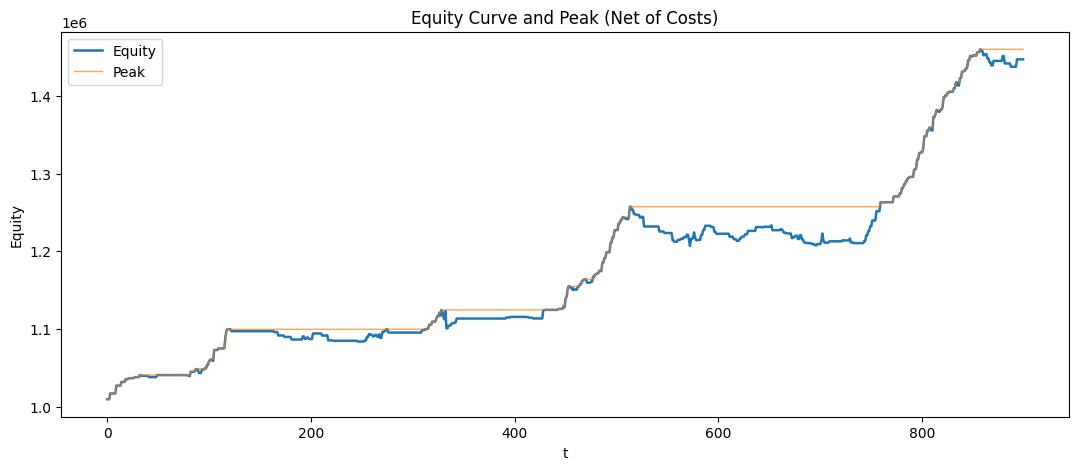

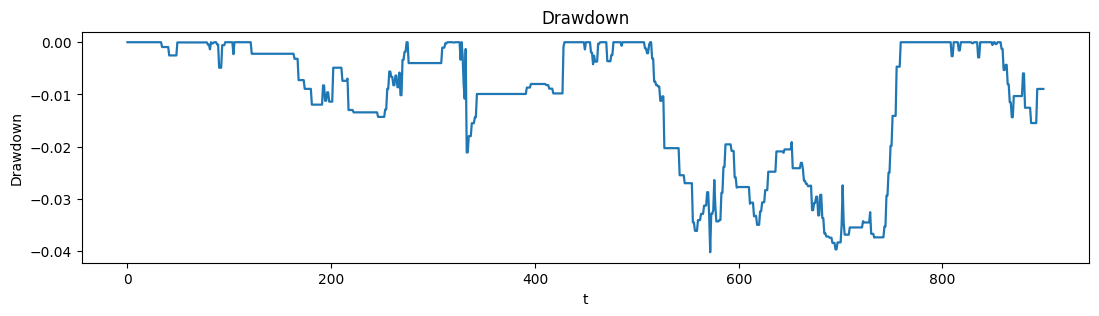

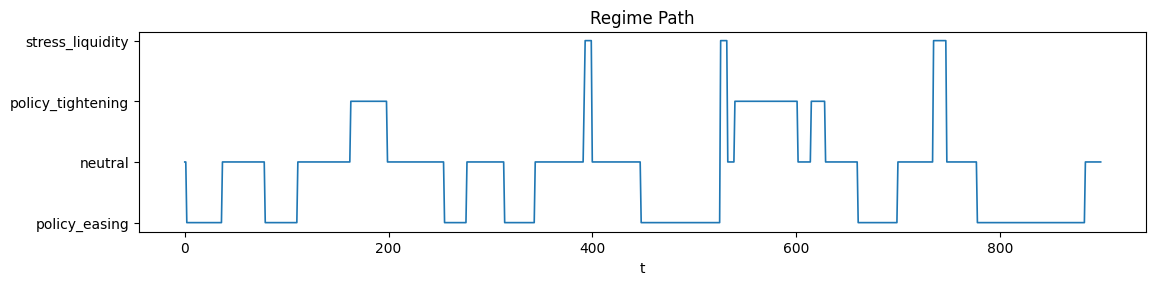

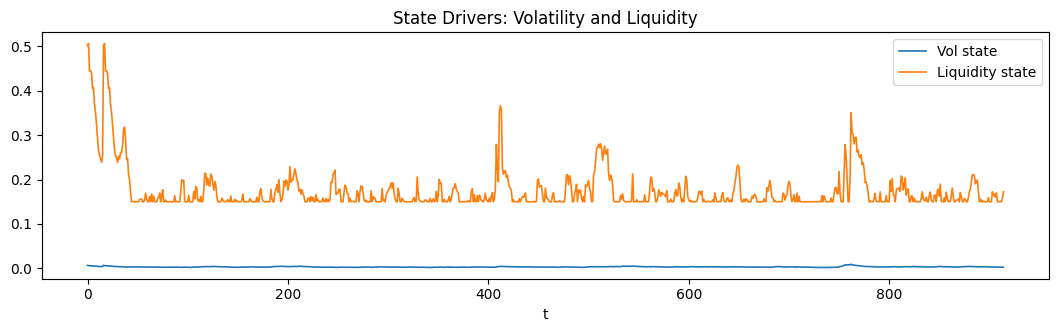

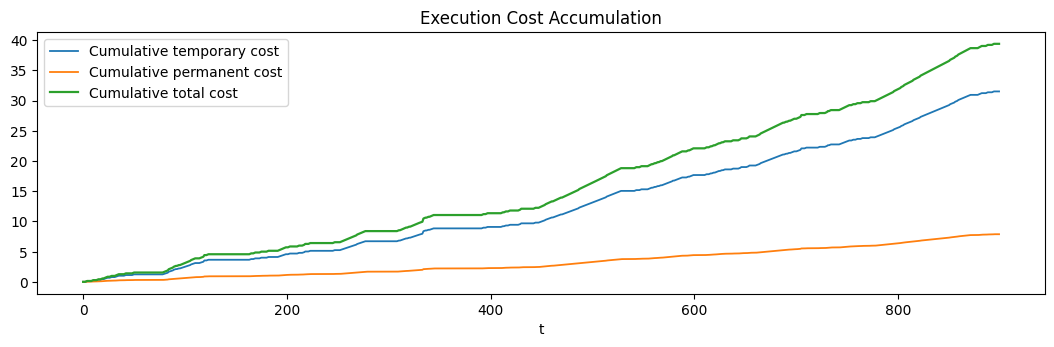

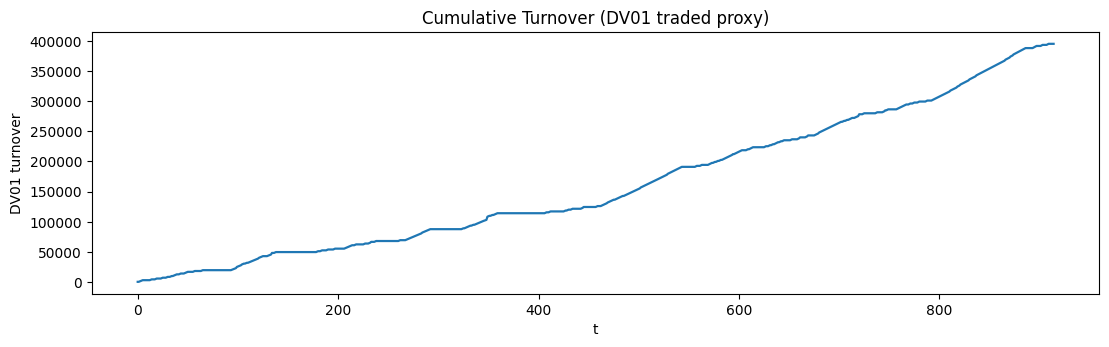

/tmp/ipython-input-2323178120.py:131: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  plt.plot(cost_per_dv01.fillna(method="ffill").values, lw=1.4)


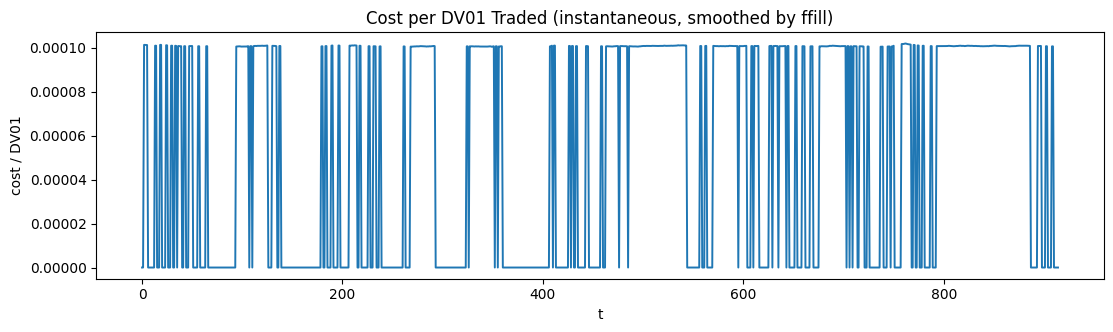

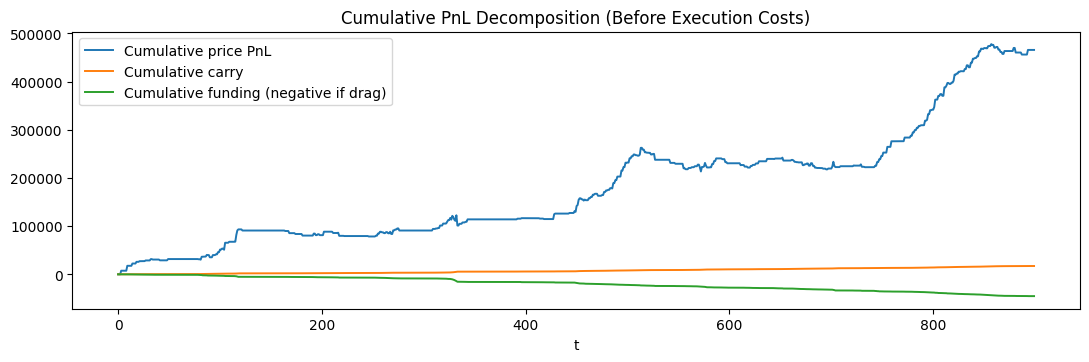

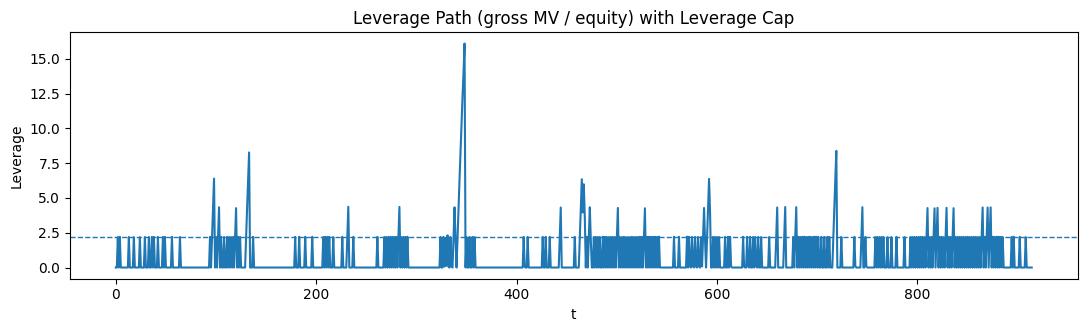

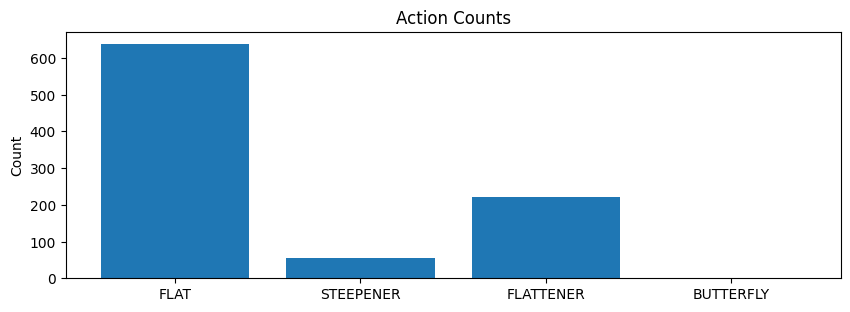

,Metric,Value
0,Final equity,1.447255e+06
1,Net PnL (final - initial),4.377927e+05
2,Ann. vol (synthetic scaling),3.723331e-02
3,Sharpe (synthetic scaling),2.728245e+00
4,Max drawdown,-4.020560e-02
5,Total execution cost,3.938117e+01
6,Cost / |gross PnL|,8.994583e-05
7,Cost / |net PnL|,8.995392e-05
8,Max leverage observed,1.609960e+01
9,DV01-limit constraint hits,0.000000e+00


,count
action,
FLAT,639
STEEPENER,54
FLATTENER,222
BUTTERFLY,0


,Telemetry,Value
0,LLM calls (approx),915.000000
1,LLM ok-rate,0.757377
2,DV01-limit hits,0.000000
3,Leverage scalings,273.000000
4,Delever overrides,0.000000
5,Stop-active steps,0.000000
6,Total turnover (DV01),395270.828823
7,Total cost,39.381167


,Mechanism,Observation,Fragility,Execution Note
0,Policy pins the front end; term premium and ri...,Shape dislocations (slope/fly) can mean-revert...,DV01-neutral does not eliminate convexity/fund...,Nonlinear impact scales with turnover and illi...


,t,regime,action,llm_ok,llm_latency_ms,constraint_hit_dv01,constraint_hit_leverage,override_delever,dv_trade,cost_total,pnl_price,pnl_carry,pnl_funding,equity
903,888,neutral,FLAT,True,738.872262,False,False,False,887.083059,0.089211,0.000000,0.000000,-0.00000,1.437715e+06
904,889,neutral,FLAT,True,820.844037,False,False,False,0.000000,0.000000,0.000000,0.000000,-0.00000,1.437715e+06
905,890,neutral,FLAT,True,821.915914,False,False,False,0.000000,0.000000,-0.000000,0.000000,-0.00000,1.437715e+06
906,891,neutral,FLAT,True,1047.953125,False,False,False,0.000000,0.000000,0.000000,0.000000,-0.00000,1.437715e+06
907,892,neutral,FLAT,True,831.852208,False,False,False,0.000000,0.000000,-0.000000,0.000000,-0.00000,1.437715e+06
908,893,neutral,STEEPENER,False,976.091366,False,True,False,886.752475,0.089143,9614.546778,63.259456,-138.02063,1.447255e+06
909,894,neutral,FLAT,True,818.818571,False,False,False,886.900866,0.089152,0.000000,0.000000,-0.00000,1.447255e+06
910,895,neutral,FLAT,True,876.351141,False,False,False,0.000000,0.000000,0.000000,0.000000,-0.00000,1.447255e+06
911,896,neutral,FLAT,True,818.090544,False,False,False,0.000000,0.000000,0.000000,0.000000,-0.00000,1.447255e+06
912,897,neutral,FLAT,True,949.250428,False,False,False,0.000000,0.000000,-0.000000,0.000000,-0.00000,1.447255e+06


In [16]:
# CELL 10 — Diagnostics + interpretive table (mechanism-first, execution-first, telemetry-aware)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Guardrails ---
if "df" not in globals() or df is None or len(df) == 0:
    raise RuntimeError("No backtest logs found. Ensure Cell 9 ran and produced `df`.")

# --- Core series ---
eq = pd.Series(equity, name="equity")
eq = eq.replace([np.inf, -np.inf], np.nan).fillna(method="ffill").fillna(eq.iloc[0])

peak_series = eq.cummax()
dd = (eq / peak_series) - 1.0

reg_path = pd.Series(regime, name="regime_id")
reg_label = pd.Series([reg_names[i] for i in reg_path.values], name="regime")

cum_temp = pd.Series(np.cumsum(cost_temp_series), name="cum_temp_cost")
cum_perm = pd.Series(np.cumsum(cost_perm_series), name="cum_perm_cost")
cum_cost = cum_temp + cum_perm

cum_price_pnl = pd.Series(np.cumsum(pnl_price_series), name="cum_price_pnl")
cum_carry = pd.Series(np.cumsum(pnl_carry_series), name="cum_carry")
cum_funding = pd.Series(np.cumsum(pnl_funding_series), name="cum_funding")

# --- Action counts ---
ac = df["action"].value_counts().reindex(ACTIONS).fillna(0).astype(int)

# --- Execution microstructure diagnostics (from logs) ---
# Turnover proxy (DV01 traded per step)
turnover_dv01 = (df["dv_trade"]).fillna(0.0)  # already in DV01 units from execution layer
cum_turnover = turnover_dv01.cumsum()

# Cost efficiency: cost per DV01 traded
cost_per_dv01 = (df["cost_total"] / (df["dv_trade"] + 1e-12)).replace([np.inf, -np.inf], np.nan)

# Liquidity / vol traces (mechanism drivers)
vol_s = df["vol"]
liq_s = df["liquidity"]

# Leverage
lev_s = df["leverage"].replace([np.inf, -np.inf], np.nan).fillna(method="ffill")

# --- Performance metrics (risk-first, no forecasting claims) ---
def ann_factor(T, dt=1.0):
    # purely synthetic scaling; keep consistent but not “real-world”
    return 252.0 / dt

ret = eq.pct_change().fillna(0.0)
af = ann_factor(len(eq), run_config["dt"])

vol_ann = float(ret.std() * np.sqrt(af))
sharpe = float((ret.mean() / (ret.std() + 1e-12)) * np.sqrt(af))
max_dd = float(dd.min())

# “Cost share” diagnostics
gross_pnl = float((cum_price_pnl.iloc[-1] + cum_carry.iloc[-1] + cum_funding.iloc[-1]))
total_cost = float(cum_cost.iloc[-1])
net_pnl = float(eq.iloc[-1] - eq.iloc[0])

cost_to_gross = float(total_cost / (abs(gross_pnl) + 1e-12))
cost_to_net = float(total_cost / (abs(net_pnl) + 1e-12))

# Constraint telemetry (from df)
dv01_hits = int(df.get("constraint_hit_dv01", pd.Series([False]*len(df))).sum())
lev_hits = int(df.get("constraint_hit_leverage", pd.Series([False]*len(df))).sum())
delever_overrides = int(df.get("override_delever", pd.Series([False]*len(df))).sum())
stop_active_steps = int(df["stopped"].sum()) if "stopped" in df.columns else 0

# LLM telemetry (from df)
llm_calls = int(run_config["policy_params"]["enable_llm"]) * len(df)  # upper bound
llm_ok_rate = float(df["llm_ok"].mean()) if "llm_ok" in df.columns else 0.0
llm_lat = df["llm_latency_ms"].dropna() if "llm_latency_ms" in df.columns else pd.Series(dtype=float)
llm_lat_avg = float(llm_lat.mean()) if len(llm_lat) else None
llm_lat_p95 = float(llm_lat.quantile(0.95)) if len(llm_lat) else None

# --- Figure 1: Equity curve + drawdown ---
plt.figure(figsize=(13,5))
plt.plot(eq.values, lw=1.8, label="Equity")
plt.plot(peak_series.values, lw=1.0, alpha=0.7, label="Peak")
plt.title("Equity Curve and Peak (Net of Costs)")
plt.xlabel("t")
plt.ylabel("Equity")
plt.legend()
plt.show()

plt.figure(figsize=(13,3))
plt.plot(dd.values, lw=1.6)
plt.title("Drawdown")
plt.xlabel("t")
plt.ylabel("Drawdown")
plt.show()

# --- Figure 2: Regime path + key state drivers (vol, liquidity) ---
plt.figure(figsize=(13,2.6))
plt.plot(reg_path.values, lw=1.2)
plt.yticks(range(len(reg_names)), reg_names)
plt.title("Regime Path")
plt.xlabel("t")
plt.show()

plt.figure(figsize=(13,3.2))
plt.plot(vol_s.values, lw=1.2, label="Vol state")
plt.plot(liq_s.values, lw=1.2, label="Liquidity state")
plt.title("State Drivers: Volatility and Liquidity")
plt.xlabel("t")
plt.legend()
plt.show()

# --- Figure 3: Costs and turnover ---
plt.figure(figsize=(13,3.4))
plt.plot(cum_temp.values, lw=1.3, label="Cumulative temporary cost")
plt.plot(cum_perm.values, lw=1.3, label="Cumulative permanent cost")
plt.plot(cum_cost.values, lw=1.6, label="Cumulative total cost")
plt.title("Execution Cost Accumulation")
plt.xlabel("t")
plt.legend()
plt.show()

plt.figure(figsize=(13,3.4))
plt.plot(cum_turnover.values, lw=1.6)
plt.title("Cumulative Turnover (DV01 traded proxy)")
plt.xlabel("t")
plt.ylabel("DV01 turnover")
plt.show()

plt.figure(figsize=(13,3.2))
plt.plot(cost_per_dv01.fillna(method="ffill").values, lw=1.4)
plt.title("Cost per DV01 Traded (instantaneous, smoothed by ffill)")
plt.xlabel("t")
plt.ylabel("cost / DV01")
plt.show()

# --- Figure 4: PnL decomposition (pre-cost) ---
plt.figure(figsize=(13,3.6))
plt.plot(cum_price_pnl.values, lw=1.4, label="Cumulative price PnL")
plt.plot(cum_carry.values, lw=1.4, label="Cumulative carry")
plt.plot(cum_funding.values, lw=1.4, label="Cumulative funding (negative if drag)")
plt.title("Cumulative PnL Decomposition (Before Execution Costs)")
plt.xlabel("t")
plt.legend()
plt.show()

# --- Figure 5: Leverage + action counts ---
plt.figure(figsize=(13,3.2))
plt.plot(lev_s.values, lw=1.5)
plt.axhline(run_config["risk_params"]["max_leverage"], lw=1.0, linestyle="--")
plt.title("Leverage Path (gross MV / equity) with Leverage Cap")
plt.xlabel("t")
plt.ylabel("Leverage")
plt.show()

plt.figure(figsize=(10,3.2))
plt.bar(ac.index, ac.values)
plt.title("Action Counts")
plt.ylabel("Count")
plt.show()

# --- Summary tables (audit-friendly) ---
summary = pd.DataFrame([
    {"Metric": "Final equity", "Value": float(eq.iloc[-1])},
    {"Metric": "Net PnL (final - initial)", "Value": float(net_pnl)},
    {"Metric": "Ann. vol (synthetic scaling)", "Value": vol_ann},
    {"Metric": "Sharpe (synthetic scaling)", "Value": sharpe},
    {"Metric": "Max drawdown", "Value": max_dd},
    {"Metric": "Total execution cost", "Value": total_cost},
    {"Metric": "Cost / |gross PnL|", "Value": cost_to_gross},
    {"Metric": "Cost / |net PnL|", "Value": cost_to_net},
    {"Metric": "Max leverage observed", "Value": float(lev_s.max())},
    {"Metric": "DV01-limit constraint hits", "Value": dv01_hits},
    {"Metric": "Leverage scaling events", "Value": lev_hits},
    {"Metric": "Delever overrides", "Value": delever_overrides},
    {"Metric": "Stop-active steps", "Value": stop_active_steps},
    {"Metric": "LLM ok-rate (decision validity)", "Value": llm_ok_rate},
    {"Metric": "LLM latency avg (ms)", "Value": llm_lat_avg},
    {"Metric": "LLM latency p95 (ms)", "Value": llm_lat_p95},
])

# Interpretive mechanism table (required)
interpretive = pd.DataFrame([
    {
        "Mechanism": "Policy pins the front end; term premium and risk reprice the long end; stress couples curve moves to liquidity.",
        "Observation": "Shape dislocations (slope/fly) can mean-revert in neutral regimes but persist under policy regimes; stress breaks typical shape heuristics.",
        "Fragility": "DV01-neutral does not eliminate convexity/funding effects; regime shifts amplify impact and destabilize PnL through execution channels.",
        "Execution Note": "Nonlinear impact scales with turnover and illiquidity; costs accumulate fastest precisely when signals look strongest (stress)."
    }
])

# Telemetry table (compact)
telemetry_table = pd.DataFrame([
    {"Telemetry": "LLM calls (approx)", "Value": llm_calls},
    {"Telemetry": "LLM ok-rate", "Value": llm_ok_rate},
    {"Telemetry": "DV01-limit hits", "Value": dv01_hits},
    {"Telemetry": "Leverage scalings", "Value": lev_hits},
    {"Telemetry": "Delever overrides", "Value": delever_overrides},
    {"Telemetry": "Stop-active steps", "Value": stop_active_steps},
    {"Telemetry": "Total turnover (DV01)", "Value": float(cum_turnover.iloc[-1])},
    {"Telemetry": "Total cost", "Value": float(total_cost)},
])

display(summary)
display(ac.rename("count").to_frame())
display(telemetry_table)
display(interpretive)

# Optional: show a small “audit window”
audit_cols = [
    "t","regime","action","llm_ok","llm_latency_ms",
    "constraint_hit_dv01","constraint_hit_leverage","override_delever",
    "dv_trade","cost_total","pnl_price","pnl_carry","pnl_funding","equity"
]
audit_cols = [c for c in audit_cols if c in df.columns]
display(df[audit_cols].tail(12))


##11.CONCLUSION

**Conclusion**

This laboratory was built to teach a particular kind of discipline: to treat a market as a set of explicit mechanisms that generate a tradable surface, and to treat trading as a constrained interaction with that surface under execution costs and risk limits. If you walk away with only a single narrative such as “steepeners work in easing” or “butterflies mean-revert,” you will have missed the point. The central lesson is not the sign of any trade; it is the structure that makes a trade meaningful and the fragility that makes it costly.

The first structural insight is that the yield curve is not a scalar. The curve is a geometry of compensation, constructed by policy expectations, term premium, risk appetite, and balance-sheet constraints. In the notebook, the curve was generated explicitly via a Nelson–Siegel representation and then anchored at the front end by a policy state. That separation—policy anchoring versus term premium movement—was not a technical trick; it was the minimal representation needed to make curve dynamics interpretable. In calm regimes, front-end anchoring creates stability and predictability in the short tenors. In policy-driven regimes, drift in the policy state introduces persistence. In stress regimes, the term premium and volatility states dominate, and the curve can move in ways that invalidate naive mean-reversion assumptions.

A second insight is that “curve shape trades” are meaningful precisely because they isolate geometry from direction, but they do not eliminate risk. DV01-neutral construction is a professional tool: it removes first-order exposure to parallel shifts and forces you to confront slope and curvature as the primary drivers of PnL. This notebook’s action space—FLAT, STEEPENER, FLATTENER, BUTTERFLY—was intentionally restricted to canonical curve expressions. That restriction made the mapping from mechanism to trade clear. When slope dislocated under a regime where mean-reversion is plausible, steepeners or flatteners become economically interpretable. When curvature distorts, butterfly exposure becomes the relevant expression. But DV01 neutrality is not a guarantee of stability. Convexity, financing drag, liquidity, and impact remain. In practice, those terms are exactly what differentiate a robust curve expression from a fragile one.

The third insight is that execution is not a nuisance term. It is the mechanism that converts theoretical exposure into realized outcomes. The notebook’s cost model was designed to behave correctly in qualitative terms: costs rise with turnover, rise with volatility, and rise with illiquidity. Impact is nonlinear, and a permanent component penalizes aggressive trading by worsening the effective mark. This matters because many intuitive curve strategies rely on frequent rebalancing—moving between steepener and flattener as slope oscillates, or harvesting curvature mean reversion via repeated fly trades. In a frictionless environment, such behavior looks harmless. In an execution-realistic environment, it can become the dominant failure mode. The same state conditions that make a signal “strong” often coincide with conditions that make execution expensive. Stress regimes compress liquidity, increase volatility, and expand impact. If the agent reacts by trading more, the environment punishes that reaction mechanically.

This laboratory also illustrates a professional fact that is frequently ignored in stylized models: constraints are part of the market. Leverage caps, DV01 limits, margin financing, drawdown stops, and deleveraging rules do not exist outside economics; they are economics. When equity declines, leverage rises mechanically for a fixed notional exposure. When leverage rises, margin and funding drag intensify. When risk limits are breached, the agent must scale down or flatten, sometimes at precisely the wrong time from the perspective of a simple signal. The notebook makes this explicit by enforcing leverage scaling, bounding per-leg DV01, and triggering stop behavior under drawdown. These rules encode survival. And survival, not optimization, is the dominant objective in real institutional settings.

The agentic architecture reinforces this viewpoint by making decisions auditable. Each time step records not only what action was taken but also the state and surface context that motivated the decision, the exact trades executed, the costs paid, the resulting leverage, and a decomposition of PnL. Telemetry adds a second layer: it measures how the decision layer behaves as a system—decision latency, fallback rates, override events, and constraint-hit frequency. This is a crucial methodological upgrade over typical demonstrations where the policy is opaque and performance is the only reported outcome. Here, the policy is constrained, the output is validated, and the system is instrumented. If the agent thrashes, you can see it in action counts and turnover. If the agent is forced flat by deleveraging, you can see overrides and stop-active steps. If costs explode in stress, you can see cost accumulation and cost-per-DV01 traces. These are not cosmetic diagnostics; they are the empirical basis for mechanism-first interpretation.

The optional LLM policy belongs in that same instrumentation framework. The LLM is not asked to invent a strategy or to forecast rates. It is asked to select among predefined actions using a compact, mechanism-relevant context and to justify its choice briefly. The validation and fallback logic are not merely “safety features”; they are necessary for scientific use. Without strict JSON parsing, action-set enforcement, and bounded rationales, LLM outputs become untestable narratives. With those controls, the LLM becomes a decision module whose behavior can be compared against a deterministic baseline under identical market paths. Telemetry then quantifies reliability: how often the LLM produces valid outputs, how often it falls back, and whether it is sensitive to regime shifts in a stable or unstable way. In a laboratory setting, this is the correct posture: treat the LLM as a bounded component, measure it, and never allow it to mutate the environment.

How should one iterate from here? The correct experimental direction is not “optimize performance” but “map fragility.” One iteration is to increase persistence of the stress-liquidity regime and observe how turnover-based strategies degrade. Another is to steepen the impact nonlinearity so that large trades become disproportionately expensive and see whether the agent adapts by preferring FLAT or by trading less frequently. You can tighten leverage caps to force earlier scaling and observe whether the strategy becomes dominated by constraint behavior rather than signal logic. You can amplify term premium shocks so that long-end repricing becomes the main driver and see whether the steepener/flattener books behave as expected under DV01 neutrality but still fail due to convexity and funding effects. You can also vary the regime transition matrix to create rare but persistent policy shifts and test whether the policy layer handles persistence without overreacting.

A second class of experiments focuses on the surface itself. Nelson–Siegel is interpretable but stylized; you can modify the factor shocks so that curvature becomes more prominent, making butterflies more central. You can impose regime-dependent anchoring strength, so policy regimes pin the front end more strongly while stress regimes decouple it. You can also make liquidity endogenous—link it to volatility and drawdowns—creating feedback loops that make execution conditions worsen when the portfolio suffers, which is often closer to real institutional behavior. The notebook already provides the scaffolding for such modifications because the state variables are explicit and logged.

A third class of experiments focuses on decision discipline. You can impose action persistence constraints (cooldowns) to prevent thrashing and quantify the resulting turnover reduction and cost savings. You can add explicit “do nothing” incentives that penalize unnecessary switching. You can tighten the rationale constraints for the LLM and see whether it remains reliable under stricter output discipline. You can compare baseline versus LLM not on equity alone but on turnover, cost-per-DV01, constraint-hit rates, and stability under regime changes. Those metrics are more aligned with professional evaluation than raw PnL in a synthetic environment.

The concluding professional intuition is therefore straightforward: curve trading is not about guessing where rates go. It is about understanding how a surface is generated, how regimes shape its dynamics, how canonical curve expressions map to that surface, and how execution and constraints determine whether the expression survives contact with reality. Mechanisms pay in calm and charge in stress. The curve’s shape can be the primary driver of theoretical PnL, but the execution layer and risk controls are often the primary drivers of realized outcomes. A mechanism-first laboratory is valuable precisely because it forces that ordering of importance.

If you use this notebook as intended, you will not leave with a trade. You will leave with a clearer mental model: the yield curve is a tradable surface produced by a small set of interpretable forces; the agent’s action space should be finite and auditable; execution costs are state-dependent and nonlinear; leverage and survival constraints dominate in stress; and diagnostics must be interpreted as evidence about mechanisms, not as proof of efficacy. That is the difference between an educational laboratory and a trading narrative. In this laboratory, structure comes first, and performance is simply one of the traces that structure leaves behind.
